In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Load the dataset
df = pd.read_csv('drug_listings.csv')

# Display the first 5 rows of the dataset
print(df.head())

                               product_title  \
0         10mg Diazepam Tabletten - 10 Stück   
1         10mg Diazepam Tabletten - 50 Stück   
2  Sonderpreis !!! 10x Diazepam Tropfen 25ml   
3   Sonderpreis !!! 2x Diazepam Tropfen 25ml   
4                        1 gr indian Ketamin   

                                 product_description ship_from    ship_to  \
0  - 10mg Diazepam Tabletten - 10 Stück\n\n- Disk...   Germany  Worldwide   
1  10 mg Diazepam / Valium / Valocordin Tabletten...   Germany  Worldwide   
2  Diazepam / Valium / Valocordin Tropfen je Flas...   Germany  Worldwide   
3  Diazepam / Valium / Valocordin Tropfen je Flas...   Germany  Worldwide   
4  Very Strong Ketamin from India be careful\n\ni...   Austria  Worldwide   

            seller    price source  
0  1XAnOYMoUsX1BXx   $67.01   1776  
1  1XAnOYMoUsX1BXx   $93.82   1776  
2  1XAnOYMoUsX1BXx  $938.32   1776  
3  1XAnOYMoUsX1BXx  $214.46   1776  
4           ACAB23   $50.00   1776  


In [3]:
# Display the last 5 rows of the dataset
print(df.tail())

                           product_title  \
194428         ∎∎ W. Domino XTC ∎∎ 220MG   
194429       ∎∎ White Domino XTC ► 220mg   
194430       ∎∎ White Domino XTC ► 220mg   
194431       ∎∎ Yellow Grenades ∎∎ 170MG   
194432  ∎∎ Yellow Grenades ∎∎ 170MG MDMA   

                                      product_description    ship_from  \
194428  White Domino XTC Pills from the Netherlands\n\...  Netherlands   
194429  White Domino XTC Pills from the Netherlands\n\...  Netherlands   
194430  White Domino XTC Pills from the Netherlands\n\...  Netherlands   
194431  White Domino XTC Pills from the Netherlands\n\...       Europe   
194432  White Domino XTC Pills from the Netherlands\n\...       Europe   

       ship_to                      seller                   price  \
194428     NaN  ∎∎ Sensi ▬ XTC, MDMA & THC  USD 42.86\nfor 5 Pills   
194429     NaN  ∎∎ Sensi ▬ XTC, MDMA & THC  USD 42.48\nfor 5 Pills   
194430     NaN  ∎∎ Sensi ▬ XTC, MDMA & THC  USD 42.82\nfor 5 Pills   
194431    

In [4]:
# Display the shape of the dataset
print(df.shape)

# Display the columns of the dataset
print(df.columns)

# Display the data types of the columns
print(df.dtypes)

(194433, 7)
Index(['product_title', 'product_description', 'ship_from', 'ship_to',
       'seller', 'price', 'source'],
      dtype='object')
product_title          object
product_description    object
ship_from              object
ship_to                object
seller                 object
price                  object
source                 object
dtype: object


In [10]:
# Display the number of missing values in each column
print(df.isnull().sum())

product_title               4
product_description     13994
ship_from              141204
ship_to                130810
seller                    130
price                     486
source                      0
dtype: int64


In [11]:
# Display the number of unique values in each column
print(df.nunique())

product_title          133799
product_description    129209
ship_from                 184
ship_to                   450
seller                   6191
price                  148991
source                      8
dtype: int64


In [12]:
# Display the summary statistics of the dataset
print(df.describe())

               product_title  \
count                 194429   
unique                133799   
top     50x  Grüne Herbalife   
freq                     181   

                                      product_description      ship_from  \
count                                              180439          53229   
unique                                             129209            184   
top     This shipment is with tracking number. The shi...  United States   
freq                                                  241          11456   

          ship_to  seller   price  source  
count       63623  194303  193947  194433  
unique        450    6191  148991       8  
top     Worldwide   rc4me  50 USD   agora  
freq        21273    1848     210  124842  


In [13]:
# Display the correlation matrix of the dataset
print(df.corr())

Empty DataFrame
Columns: []
Index: []


In [14]:
# Display the count of each unique value in the 'product_title' column
print(df['product_title'].value_counts())

50x  Grüne Herbalife                          181
10x  Grüne Herbalife                          164
25x  Grüne Herbalife                          159
5x  Grüne Herbalife                           151
100x  Grüne Herbalife                         150
                                             ... 
Custom order for A****i                         1
BUPRENORPHINE Patch -- 70ug/h -- 40mg --        1
BUPRENORPHINE Patch -- 52,5ug/h -- 30mg --      1
5 x 'Stars' 140mg MDMA                          1
∎∎ Yellow Grenades ∎∎ 170MG MDMA                1
Name: product_title, Length: 133799, dtype: int64


In [ ]:
# NLP Analysis of the 'product_title' column
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
# running pip install wordcloud if not installed
from wordcloud import WordCloud



# Download the NLTK resources 
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

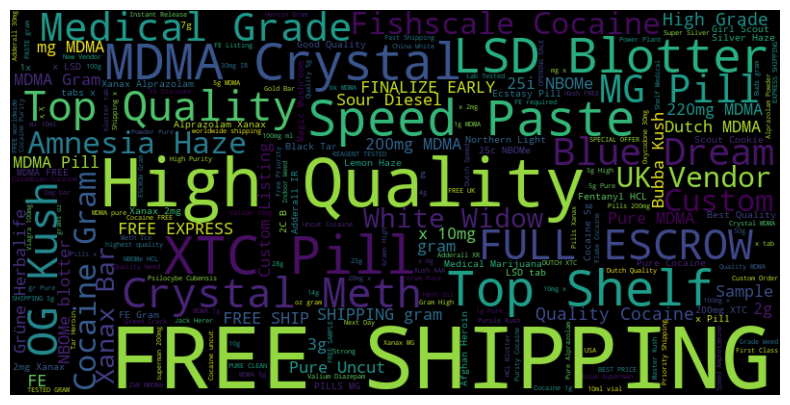

In [18]:
# Create a list of stopwords
stop_words = set(stopwords.words('english'))

# Create a WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a Porter Stemmer
stemmer = PorterStemmer()

# Tokenize the 'product_title' column
# first convert into string
df['product_title'] = df['product_title'].astype(str)
df['product_title_tokens'] = df['product_title'].apply(word_tokenize)
# TypeError: expected string or bytes-like object


# Remove stopwords from the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Lemmatize the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Stem the 'product_title' column
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Create a WordCloud of the 'product_title' column
text = ' '.join(df['product_title'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

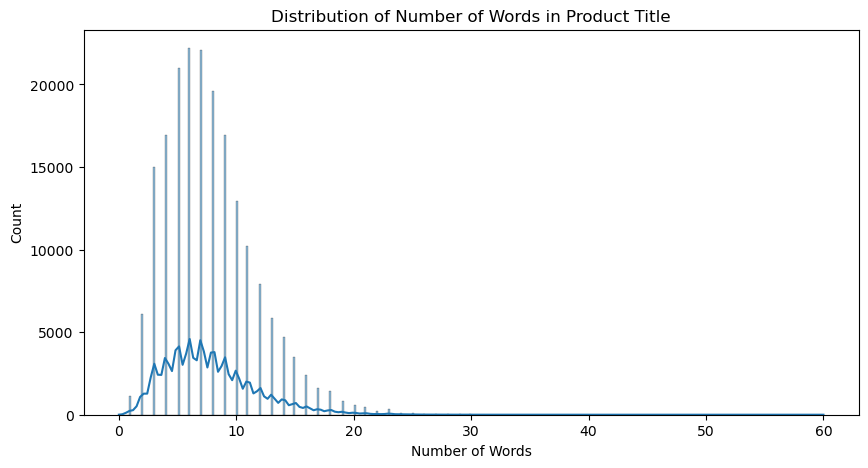

In [19]:
# Visualize the distribution of the 'product_title' column
plt.figure(figsize=(10, 5))
sns.histplot(df['product_title_tokens'].apply(len), kde=True)
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Product Title')
plt.show()


In [29]:
# print more statistics on the number and type of words in product titles
# Create a new column with the number of words in the 'product_title' column
df['num_words'] = df['product_title_tokens'].apply(len)

# Display the average number of words in the 'product_title' column
print('Average Number of Words in Product Title:', df['num_words'].mean())

# Display the maximum number of words in the 'product_title' column
print('Maximum Number of Words in Product Title:', df['num_words'].max())

# Display the minimum number of words in the 'product_title' column
print('Minimum Number of Words in Product Title:', df['num_words'].min())

# Display the most common words in the 'product_title' column
# exclude special characters and stopwords

# Create a list of special characters
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '-', '_', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/']

# Create a list of words without special characters
df['product_title_tokens'] = df['product_title_tokens'].apply(lambda x: [word for word in x if word not in special_chars])

words = [word for sublist in df['product_title_tokens'] for word in sublist]
word_freq = nltk.FreqDist(words)
print('Most Common Words in Product Title:', word_freq.most_common(50))

Average Number of Words in Product Title: 6.089002381283013
Maximum Number of Words in Product Title: 33
Minimum Number of Words in Product Title: 0
Most Common Words in Product Title: [('gram', 24463), ('x', 19274), ('mdma', 16990), ('free', 14806), ('ship', 14218), ('1', 13852), ('pill', 13004), ('qualiti', 12674), ('pure', 11958), ('10', 11147), ('cocain', 10398), ('1g', 9257), ('100', 8944), ('crystal', 8008), ('mg', 7792), ('high', 7424), ('fe', 7387), ('5', 7226), ('kush', 6542), ('lsd', 6506), ('grade', 6478), ('tab', 6313), ('50', 5952), ('blotter', 5749), ('xtc', 5410), ('xanax', 5400), ('white', 5288), ('uk', 5125), ('top', 5056), ('--', 5017), ('weed', 5003), ('oz', 4970), ('heroin', 4871), ('hash', 4807), ('2', 4681), ('10mg', 4650), ('blue', 4615), ('5g', 4587), ('indoor', 4582), ('speed', 4543), ('dutch', 4385), ('10g', 4164), ('gr', 4102), ('3.5g', 4099), ('uncut', 3982), ('haze', 3950), ('escrow', 3918), ('7g', 3883), ("'s", 3753), ('powder', 3674)]


In [28]:
# Classification of fraudolent listings using NLP insights
# we classify listings as fraudulent when there are exclamation marks and misspelled words in the product title, such as qualiti

# Create a new column with the number of exclamation marks in the 'product_title' column
df['num_exclamation_marks'] = df['product_title'].apply(lambda x: x.count('!'))

# Create a new column with the number of misspelled words in the 'product_title' column
df['num_misspelled_words'] = df['product_title_tokens'].apply(lambda x: sum([1 for word in x if 'qualiti' in word]))

# Create a new column to classify listings as fraudulent or not
df['is_fraudulent'] = (df['num_exclamation_marks'] > 0) | (df['num_misspelled_words'] > 0)

# Display the count of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts())

# Display the percentage of fraudulent and non-fraudulent listings
print(df['is_fraudulent'].value_counts(normalize=True))

# True means that the listing is fraudulent, while False means that the listing is not fraudulent.

False    168778
True      25655
Name: is_fraudulent, dtype: int64
False    0.868052
True     0.131948
Name: is_fraudulent, dtype: float64
